In [1]:
# Jade Chongsathapornpong, August 2023
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, KMeans

from larch import Group
from larch.io import read_ascii, h5group # to read averaged files from PyMCA
from larch.io.specfile_reader import DataSourceSpecH5 # to read files directly from BM23 HDF5
from larch.xafs import sort_xafs, pre_edge, autobk

# Time evolution in PCA representation
This is the same workflow as `xas-compare-pca` but modified to handle plotting "paths" through the PC space.

In [2]:
### Zn K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# These are all the end points
names_all = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')

# This is what we want to fit the PCA to
names_for_pca = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit',
         'W32_HEO-Co_RT', 'W36_Zn_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W46_ZnMg_RT', 'ZnO_KOCH_RT')

# These are where to find the HDF5 files, their names, and the relevant scan numbers (see logbook_final.xlsx for info) 
# e.g. (21, 145, 1) will go through all scans from 21 to 144, and (147, 185, 2) will go 147, 149, 151, ...
xanes_info_dict = {'W29_HEO-Ni': ['../Data/BM23/WAM29B/WAM29B_TT/WAM29B_TT.h5', (21, 145, 1), (205, 236, 1)],
         'W30_HEO-Mg': ['../Data/BM23/WAM30C/WAM30C_TT/WAM30C_TT.h5', (21, 146, 1), (206, 237, 1)],
         'W36_Zn'    : ['../Data/BM23/WAM36/WAM36_TT/WAM36_TT.h5', (16, 149, 1), (165, 196, 1)],
         'W37_ZnCo'  : ['../Data/BM23/WAM37C/WAM37C_TT_0002/WAM37C_TT_0002.h5', (1, 102, 1), (118, 149, 1)],
         'W39_HEO'   : ['../Data/BM23/WAM39C/WAM39C_TT/WAM39C_TT.h5', (21, 146, 1), (206, 237, 1)]}

### Cu K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Cu_Kedge'
# names_all = ('HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'CuO_Aldritch_RT')
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit',
#          'CuO_Aldritch_RT']

### Co K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal',
#          'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #  'W39_HEO_900C' removed because it's too short?
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W35_Co_RTInit',
#          'W37_ZnCo_RTInit',
#          'W39_HEO_RTInit',
#          'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT']

## Loading and interpolating data

In [3]:
def interpolate_xas(in_energies, in_signals, targets=None):
    """Args:
        - in_energies (list or iterable of 1D array) energies or wavenumbers, or single 1D array
        - in_signals (list of 1D array)
        - target_energies (1D array) if None, uses the SHORTEST array in in_energies, 
            and interpolates the remaining in_signal arrays to match it.
    Returns:
        - targets (1D array) a single array of energies (or wavenumbers) interpolated to
        - out_signals (list of 1D array) all the interpolated signals
    """
    if targets is None:
        spectrum_lengths = [len(E) for E in in_energies]
        print("Lengths of spectra:", spectrum_lengths)
        shortest_idx = np.argmin(spectrum_lengths)
        print(f"Mapping to {len(in_energies[shortest_idx])} points from spectra up to {np.max(spectrum_lengths)} long")
        targets = in_energies[shortest_idx]
        
    if isinstance(in_energies, list):
        out_signals = [np.interp(targets, energy, signal) for energy, signal in zip(in_energies, in_signals)]
    else:
        out_signals = [np.interp(targets, in_energies, signal) for signal in in_signals]
        
    return targets, out_signals

def _larchgroup_init(g, name):
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    g.norm_poly = 1.0 * g.norm
    autobk(g) # use defaults for auto-background-subtraction
    return g
    
def larch_load_group(path, name, labels='energy_cenc, mu_fluo'):
    """Args:
        - path to csv file with labels, e.g. energy_cenc and mu_fluo (can be changed)
        - name to associate with the group
        - labels of columns to read
    Returns:
        - a Larch Group object with attributes initialized as done in xas_viewer
            according to the Larch buffer"""
    g = read_ascii(path, labels=labels)
    return _larchgroup_init(g, name)

def load_from_dictionary(namesdict, mode, labels=('energy_cenc', 'mu_fluo'), kweight=2):
    """Args:
        - namesdict: dictionary with information formatted as in above cell, names_xanes
        - mode: 'chik' or 'mu'
        - labels of columns to read (note it's formatted differently from the way Larch read_ascii takes)
    Returns:
        - a dictionary {name: [[scan ID, k array, chi(k) array], ... ] } if mode 'chik', or energy/mu if 'mu'"""
    ret = {name : [] for name in namesdict}
    for name, info in namesdict.items():
        print("Loading spectra from", name)
        f = DataSourceSpecH5(info[0])
        for start, end, step in info[1:]:
            for scanid in range(start, end, step):
                f.set_scan(scanid)
                energy = f.get_array('energy_cenc')[1:-1]
                mu = f.get_array('mu_fluo')[1:-1]
                group = Group(name=f'{name}_{scanid}', path=info[0])
                group.data = np.vstack((energy, mu))
                _larchgroup_init(group, f'{name}_{scanid}')
                if mode == 'chik':
                    ret[name].append([scanid, group.k, group.chi])
                elif mode == 'mu':
                    ret[name].append([scanid, group.energy, group.mu])
                else:
                    raise ValueError('Invalid mode.')
    return ret
                
def load_from_names(names, mode):
    """Args:
        - names of averaged spectra files (formatted as in the first cell)
        - mode 'chik' or 'mu'
        - kweight (if mode 'chik')
    Returns:
        - ordered list of arrays of wavenumbers (mode chik) or energies (mu) corresponding to:
        - ordered list of arrays of relative absorption weighted by k^kweight (chik) or absorptions (mu)
    Uses interpolate_xas to map all signals down to one signal's wavenumbers
    """
    x = []
    y = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_group(path, name)
        if mode == 'chik':
            kweight = 2
            x.append(lgrp.k)
            y.append(lgrp.chi * np.power(lgrp.k, kweight))
        elif mode == 'mu':
            x.append(lgrp.energy)
            y.append(lgrp.mu)
        else:
            raise ValueError('Invalid mode.')
    return interpolate_xas(x, y)

In [61]:
# Load dataset
mode = 'mu' # 'chik'
K, CHIK = load_from_names(names_all, mode) # the long spectra
K_pca, CHI_pca = load_from_names(names_for_pca, mode) # PCA expects (n_samples (each signal is a "sample"), n_features (data pts/signal))
xanes_dict = load_from_dictionary(xanes_info_dict, mode) # the near-edge spectra - note this may take a lot of memory

Lengths of spectra: [2096, 2095, 2099, 2086, 2095, 2098, 2086, 2095, 2095, 2099, 2100, 2095, 2100, 2100, 2095, 2094, 2086, 2096, 2095]
Mapping to 2086 points from spectra up to 2100 long
Lengths of spectra: [2096, 2095, 2095, 2095, 2095, 2095, 2095, 2096, 2095]
Mapping to 2095 points from spectra up to 2096 long
Loading spectra from W29_HEO-Ni
Loading spectra from W30_HEO-Mg
Loading spectra from W36_Zn
Loading spectra from W37_ZnCo
Loading spectra from W39_HEO


Shortest XANES had 599 points, while the longest had 599
Mapping all to 599 points


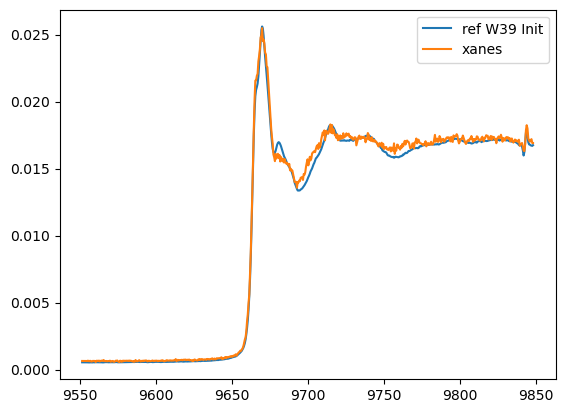

In [34]:
# Interpolate the XANES spectra to get matching energies
shortest = None
longest = []
for name, xanes in xanes_dict.items():
    if shortest is None:
        shortest = xanes[0][1]
    for scans in xanes:
        print(len(scans[1]))
        # item is [scan ID, k/E, chi(k)/mu(E)]
        if len(scans[1]) < len(shortest):
            shortest = scans[1]
        if len(scans[1]) > len(longest):
            longest = scans[1]
# note this is inaccurate if the cell is run twice after loading the dataset, as the modification is in-place
print(f"Shortest XANES had {len(shortest)} points, while the longest had {len(longest)}")

for name, xanes in xanes_dict.items():
    for scans in xanes:
        scans[2] = np.interp(shortest, scans[1], scans[2])
        scans[1] = shortest
print(f"Mapping all to {len(shortest)} points")

# Interpolate the long spectra into the range of the XANES spectra
K_interp, CHI_interp = interpolate_xas(K, CHIK, targets=shortest)
_, CHI_pca_interp = interpolate_xas(K_pca, CHI_pca, targets=shortest)

# plot a few examples
plt.plot(K_interp, CHI_interp[-5], label='ref W39 Init')
plt.plot(K_interp, xanes_dict['W39_HEO'][100][2], label='xanes')
plt.legend()
plt.show()

## PCA and Clustering

[9.51581337e-01 2.92851442e-02 1.77002945e-02 6.43119920e-04]


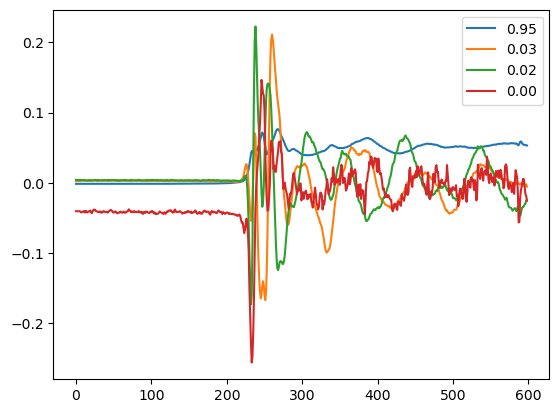

In [60]:
A = np.array(CHI_pca_interp)
pca = PCA(n_components=4) # adjust this number to get appropriate dimensional embeddings.
pca.fit(A)
print(pca.explained_variance_ratio_)
for i in range(4):
    plt.plot(pca.components_[i], label=f"{pca.explained_variance_ratio_[i]:.2f}")
plt.legend()
# plt.savefig("Output/BM23/Zn_mu_PC")
plt.show()

# Save the principal components
# np.savetxt('Output/BM23/principalcomponents_Zn_mu_short.csv', pca.components_.transpose(), delimiter=',')

In [58]:
# apply PCA to reference signals
reduced = pca.transform(np.array(CHI_interp))
print(f"Reference: {reduced.shape[0]} signals embedded in {reduced.shape[1]} dimensions.") 
# Save the PCA embeddings of each reference signal
# embedding_df = pd.DataFrame(reduced)
# embedding_df['sample'] = names_all
# embedding_df.to_csv('Output/BM23/pca_embeddings_Zn_mu_short.csv')

# apply PCA to the XANES time evolving signals
evolutions = {name : [] for name in xanes_dict} # list will contain (scanid, PCA embedding)
for name, xanes in xanes_dict.items():
    for scanid, _, y in xanes:
        evolutions[name].append((scanid, pca.transform(y.reshape(1,-1))))

# Perform clustering on the references
ap = AffinityPropagation().fit(reduced)
clusterings = {key: [] for key in np.unique(ap.labels_)}
for i, name in enumerate(names_all):
    clusterings[ap.labels_[i]].append((i, name))
    
print(clusterings)

Reference: 19 signals embedded in 4 dimensions.
{0: [(0, 'HEO-SSR_RT'), (1, 'W29_HEO-Ni_RTInit'), (2, 'W29_HEO-Ni_RTFinal'), (3, 'W29_HEO-Ni_900C'), (14, 'W39_HEO_RTInit'), (15, 'W39_HEO_RTFinal'), (16, 'W39_HEO_900C')], 1: [(4, 'W30_HEO-Mg_RTInit'), (5, 'W30_HEO-Mg_RTFinal'), (6, 'W30_HEO-Mg_900C'), (7, 'W32_HEO-Co_RT'), (8, 'W36_Zn_RTInit'), (9, 'W36_Zn_RTFinal'), (10, 'W36_Zn_900C'), (17, 'W46_ZnMg_RT')], 2: [(11, 'W37_ZnCo_RTInit'), (12, 'W37_ZnCo_RTFinal'), (13, 'W37_ZnCo_900C'), (18, 'ZnO_KOCH_RT')]}


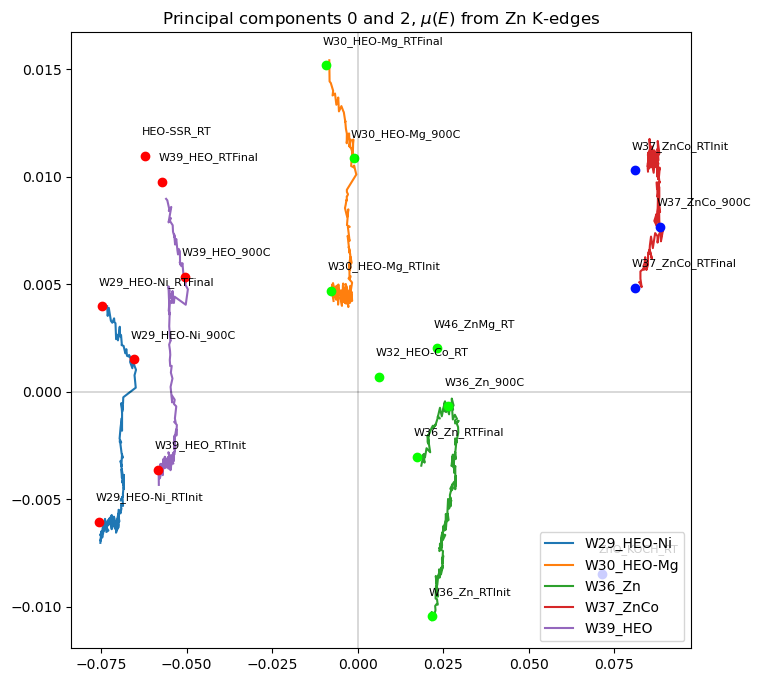

In [57]:
dim0 = 0 # 0, 1, 2, 3, 4, 5; dimensions of the PCA
dim1 = 2

adj_text_idx = ()#(13, 15) # indices into names_all for which to adjust text position

fig, ax = plt.subplots(figsize=(8,8))

# Plot evolutions
for name, embeddings in evolutions.items():
    signalmat = np.array([e[1] for e in embeddings]).squeeze() # note this assumes scanid were sorted
    x = signalmat[:,dim0]
    y = signalmat[:,dim1]
    ax.plot(x, y, label=name)
    
# Plot references
for i, signalvec in enumerate(reduced):
    adj = 0.2 if i in adj_text_idx else 0.
    ax.axhline(0, linewidth=0.01, color='k')
    ax.axvline(0, linewidth=0.01, color='k')
    ax.plot(signalvec[dim0], signalvec[dim1], 'o', c=cm.hsv(ap.labels_[i]/(max(ap.labels_) + 1)))
    ax.text(signalvec[dim0]-0.001-adj, signalvec[dim1]+0.001+adj, names_all[i], fontsize=8)
ax.set_title(f"Principal components {dim0} and {dim1}, $\mu(E)$ from Zn K-edges")

plt.legend(loc='lower right')
# plt.savefig(f"Output/BM23/Zn_PCA/PCA_Zn_mu_short_{dim0}_{dim1}", dpi=300)
plt.show()

## Replotting the spectra that were clustered according to the PCA
I looked along dimensions 0, 1, and 2, and corroborated groupings between them. This could be automated using something like K-means or medoids.
I plotted things that are in the same clusters, and in far-separated clusters. I found the PCA overfits to temperature dependence, but is still useful.

In [ ]:
ref_root = r'FDMNES'
names_ref = ['CoO_Oh', 'Co15Zn85O_Co','Co3O4_Oh', 'Co3O4_Td']

kwt = 2
ref_scale = 0.7

clusternames = {0: 'R-Oh mix?', 1: 'Sp-Td,Oh', 2: 'R-Oh', 3: 'R-Oh / Sp-Td,Oh mix', 4: 'W-Td'}

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(1,7.22)
spec_offset = 0

# Plot experimental data
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(1.2, spec_offset+1.5, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        chis = CHIK[index] + spec_offset
        ax.plot(K, chis, label=f'{samplename} {clustername}')
    spec_offset -= 4.5

ax.set_yticks([])
ax.set_xlabel('Wavenumber (1/A)')
ax.set_ylabel('$\chi(k)$ (arb)')
ax.set_title('Co K-edge fine structure clustered by PCA')
ax.legend(ncol=1, loc=(1.05, 0.08), fontsize=9)
plt.tight_layout()
# plt.savefig('Output/BM23/Co_ClusteredSpecs', dpi=300)
plt.show()

# Comparing to FDMNES simulations
Below I'll plot the spectra without background subtracted ($\mu$ instead of $\chi$), as the `larch` `autobk` seems to dislike the simulated spectra in my case.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
spec_offset = 0
edge_energy = 7712

# plot experiment
energy, mus = load_from_names(names_all, 'mu')
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(edge_energy + 70, spec_offset+0.35, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        ax.plot(energy, mus[index] / np.max(mus[index]) + spec_offset, label=f'{samplename} {clustername}')
    spec_offset -= 1

# plot references
for name in names_ref:
    path = join(ref_root, name, name + '.txt')
    ax.text(edge_energy + 70, spec_offset+0.35, name, fontsize=8)
    data = np.genfromtxt(path, skip_header=5).transpose()
    E = data[0]
    mu = data[1] / np.max(data[1])
    mu_conv = convolution1D.conv(E, mu, np.array([2. for e in E]), e_cut=-4., kernel='lorentzian') # constant broadening w.r.t. energy
    ax.plot(data[0] + edge_energy, mu_conv / np.max(mu_conv) + spec_offset, label=name)
    spec_offset -= 1

plt.xlim(edge_energy - 10, edge_energy + 105)
plt.legend(ncol=1, loc=(1.05, 0.0), fontsize=8)
plt.tight_layout()
plt.savefig('Output/BM23/Co_withRef', dpi=300)
plt.show()